## Waves in one dimension

### Advection equation

First we are going to study the one-dimensional advection equation 
 \begin{align}
     \frac{\partial }{\partial t} n= - a \frac{\partial}{\partial x} n 
 \end{align}
We are going to compare the first order upwind scheme with a centered differences scheme. Since forward in time centered in space is unconditionally unstable we add artificial diffusion to the latter.
 We discretize space with a cell-centered grid on the domain $[-L_\parallel /2 ; L_\parallel/2]$, where $L_\parallel = 2\pi q R_0$ with $q=3$ and $R_0=0.545$m approximating the length of a fieldline from divertor to divertor in the Compass SOL. We use $N_x$ points.
 
 In time we use the Bogacki-Shampine adaptive method of order 3 (adaption of order 2).
 
 We use Neumann boundary conditions and as initial condition we use the classical problem of a step function
 \begin{align}
    n(x,0) = \begin{cases} 1 \text{ for } x < x_a \\ 0 \text{ else}\end{cases}
 \end{align}
    

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import feltorutilities as fp
from scipy.integrate import solve_ivp

In [2]:
def advection_grid(p):
    Nx = p["grid"]["Nx"]
    lx = p["grid"]["lx"]
    xi = np.zeros(Nx)
    hx = lx / Nx  
    xi[0] = -lx/2 + hx/2
    for i in range(1,Nx):
        xi[i] = xi[i-1]+hx
    return xi
# Define the function to integrate (the advection scheme)
def advection( t, y, p):
    xi = advection_grid(p)
    Nx = np.size(xi)
    yp = np.zeros(Nx)
    yp[:] = y[:]
    yg = np.zeros( Nx+2) # ghost cells
    yg[0:Nx] = y[0:Nx] 
    scheme = p["advection"]["type"]
    vel = p["physical"]["velocity"]
    assert( vel > 0)
    regularization = p["regularization"]["type"]
    hx = xi[1]-xi[0] # assume equidistant
    if( scheme == "upwind"):
        yg[-1] = yg[0]
        for i in range(0,Nx) :
            yp[i] = -vel*(yg[i]-yg[i-1])/hx
    elif( scheme == "upwind2"):
        yg[-1] = yg[0]
        yg[-2] = yg[0]
        for i in range(0,Nx) :
            yp[i] = -vel*(3*yg[i]-4*yg[i-1]+yg[i-2])/2/hx
    elif( scheme == "centered"):
        yg[-1] = yg[0]
        yg[Nx] = yg[Nx-1]
        for i in range(0,Nx) :
            yp[i] = -vel*(yg[i+1]-yg[i-1])/2/hx
    if( regularization == "diffusion"):
        yg[-1] = yg[0]
        yg[Nx] = yg[Nx-1]
        nu = p["regularization"]["nu"]
        assert(nu>=0)
        for i in range(0,Nx) :
            yp[i] = yp[i] + nu*(yg[i+1] - 2*yg[i]+yg[i-1])/hx**2
            
    return yp

In [3]:
def heaviside( x, x_a, sign):
    if( (x < x_a and sign > 0) or ( x > x_a and sign < 0)):
        return 1
    else :
        return 0
    
def sine( x, n_0, amp, k, x_0):
    return n_0 + amp*np.sin( k*(x-x_0) )

In [4]:
# Define the integration program 
def integrate_advection( p):
    init = p["init"]["type"]
    Nx = p["grid"]["Nx"]
    lx = p["grid"]["lx"]
    xi = advection_grid(p)
    y = np.zeros(Nx)
    # Initial condition
    if init == "step":
        x_a = p["init"]["x_a"]
        for i in range(0,Nx):
            y[i] = heaviside( xi[i], x_a, +1)
    elif init == "wave":
        n_0 = p["init"]["n_0"]
        amp = p["init"]["amp"]
        k   = p["init"]["k"]
        x_0 = p["init"]["x_0"]
        for i in range(0,Nx):
            y[i] = sine( xi[i], n_0, amp, k, x_0)
    tableau = p["timestepper"]["tableau"]
    tend = p["output"]["tend"]
    sol = solve_ivp(fun = lambda t,y : advection(t,y,p), t_span = [0, tend], y0 = y, method=tableau)
    return sol
        

In [5]:
show = ["name", "mu", "R_0", "a_0", "beta", "resistivity",
        "T_e", "n_0", "B_0", "CFL_diff", "epsilon_D",
        "omega_0_inv", "viscosity_e", "viscosity_i", "rho_s"]
physical={"name" : "Compass",
    "beta" : 1e-4, "resistivity": 1e-4, #change both to change n_0
    "tau" : 1,
    "m_i" : fp.deuteron_mass, "R_0" : 545, "R": 0.545,
    "a": 0.175, "q":2, "scaleR" : 1.45, "Nz" : 32}
fp.numerical2physical( physical, physical)
table = dict()
for s in show :
    table[s] = fp.parameters2quantity( physical, s)
    if s == "omega_0_inv":
        table[s] = 1e-3/fp.parameters2quantity( physical, s)
    print( s, "\t\t", table[s])
table["lx"] = 2*np.pi*table["R_0"]*3
print( "lx", "\t\t", table["lx"])

Invert for given R
name 		 Compass
mu 		 -0.00027244371074816386
R_0 		 545
a_0 		 175.00000001100324
beta 		 0.0001
resistivity 		 0.0001
T_e 		 7.77608857067851
n_0 		 1.0365292385362574
B_0 		 0.40283899781623667
CFL_diff 		 0.883873115023735
epsilon_D 		 4.1458919332419e-05
omega_0_inv 		 19303.21695220677
viscosity_e 		 3700.000000592561
viscosity_i 		 113.89049597255578
rho_s 		 0.0009999999999371243
lx 		 10273.007977238623


In [6]:
params = {
    "grid" : {
        "Nx" : 32,
        "lx" : table["lx"]
    },
    "init":
    {
        "type":"step",
        "x_a" : -0.2*table["lx"]
    },
    "advection" : {"type" : "upwind"},
    "regularization" : {"type" : "none"},
    "timestepper":
    {
        "tableau" : "RK23"
    },
    "physical":
    {
        "velocity" : 1.0
    },
    "output":
    {
        "tend" : 0.25*table["lx"] # with velocity 1 
    }
}


In [7]:
def plot_upwind( p):
    xi = advection_grid(p)

    analytic = np.zeros( p["grid"]["Nx"])
    if ( p["init"]["type"] == "step") :
        for i in range( 0, p["grid"]["Nx"]) :
            analytic[i] = heaviside( xi[i], p["init"]["x_a"]+
                                p["physical"]["velocity"]*p["output"]["tend"], +1)
    if ( p["init"]["type"] == "wave") :
        n_0 = p["init"]["n_0"]
        amp = p["init"]["amp"]
        k   = p["init"]["k"]
        x_0 = p["init"]["x_0"]
        for i in range(0,p["grid"]["Nx"]):
            analytic[i] = sine( xi[i], n_0, amp, k, x_0+p["physical"]["velocity"]*p["output"]["tend"])

    frows = 1
    fcols = 1

    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*10,frows*8),dpi= 80, facecolor='w', edgecolor='k')
    im = ax.plot(xi,analytic, label="analytical")
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html
    rr = 0
    cc = 0   
    p["advection"]["type"] = "upwind"
    p["regularization"] = {"type": "none"}
    sol = integrate_advection(p)
    last_idx = np.size(sol.t)-1
    im = ax.plot(xi,sol.y[:,last_idx], label="upwind")
    
    p["advection"]["type"] = "upwind2"
    p["regularization"] = {"type": "none"}
    sol = integrate_advection(p)
    last_idx = np.size(sol.t)-1
    im = ax.plot(xi,sol.y[:,last_idx], label=r"upwind2 $\nu=0$")
    
    p["advection"]["type"] = "upwind2"
    p["regularization"] = {"type": "diffusion", "nu" : 50}
    sol = integrate_advection(p)
    last_idx = np.size(sol.t)-1
    im = ax.plot(xi,sol.y[:,last_idx], label=r"upwind2 $\nu=50$")

    p["advection"]["type"] = "centered"
    p["regularization"] = {"type": "none"}
    sol = integrate_advection(p)
    last_idx = np.size(sol.t)-1
    im = ax.plot(xi,sol.y[:,last_idx], label=r"centered $\nu=0$")


    p["advection"]["type"] = "centered"
    p["regularization"] = {"type": "diffusion", "nu" : 50}
    sol = integrate_advection(p)
    last_idx = np.size(sol.t)-1
    im = ax.plot(xi,sol.y[:,last_idx], label=r"centered $\nu=50$")

    ax.set_title( f"Advection equation in 1D with Nx = {p['grid']['Nx']} points")
    ax.set_xlabel( r"s [$\rho_s$]")
    ax.set_ylabel("n")
    ax.legend()


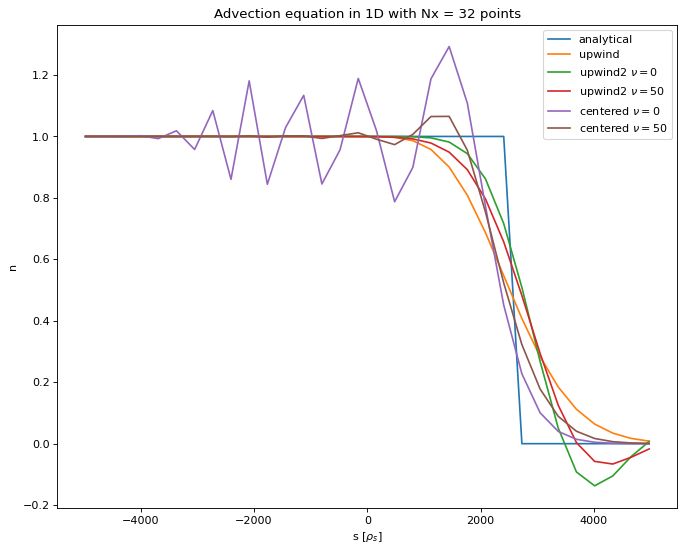

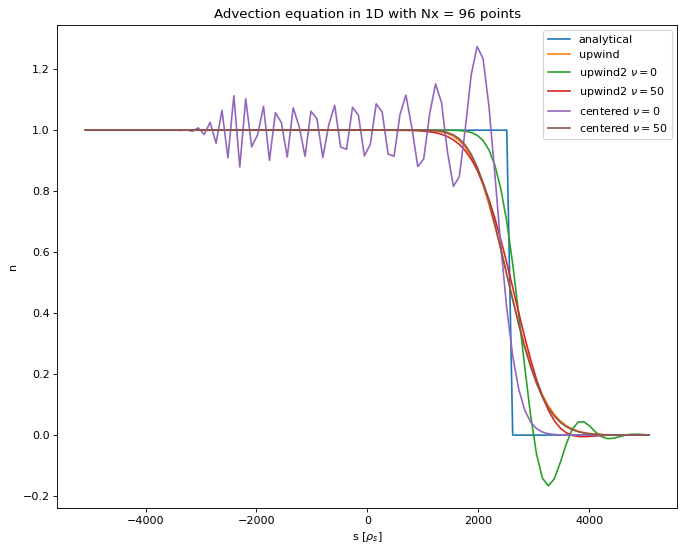

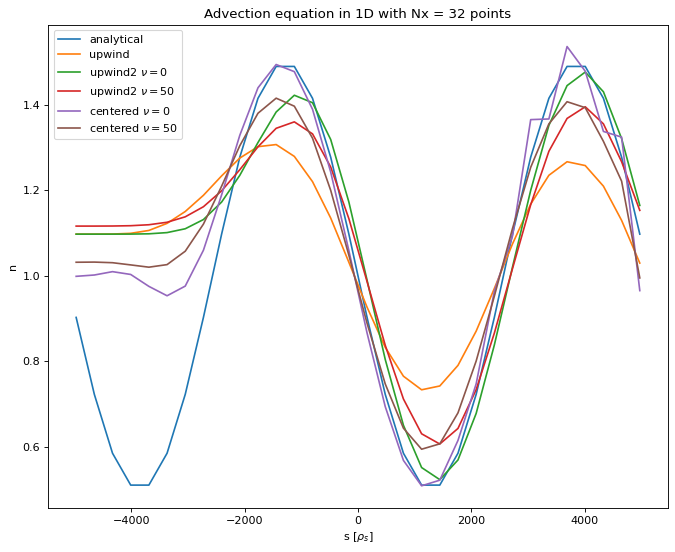

In [8]:
params["init"] = {"type" : "step", "x_a" : -0.2}
params["grid"]["Nx"] = 32
plot_upwind(params)
params["grid"]["Nx"] = 96
plot_upwind(params)
params["grid"]["Nx"] = 32
params["init"] = {"type" : "wave", "amp" : 0.5, "n_0" : 1, "k" : 4*np.pi/params["grid"]["lx"], "x_0" : 0}
plot_upwind(params)

We find the expected results:
- the upwind scheme of first order does not produce oscillations and has inherent numerical diffusion
- the centered scheme without diffusion is unconditionally unstable and produces lots of oscillations
- the upwind scheme of 2nd order produces some oscillations downstream
- adding the correct amount of numerical diffusion to the 2nd order schemes depends on the resolution

### Navier stokes equation

We now turn to the one-dimensional compressional Navier-Stokes equation
 \begin{align}
     \frac{\partial }{\partial t} n&= - \frac{\partial}{\partial x} (un ) \\
     \frac{\partial }{\partial t} u&= - u\frac{\partial}{\partial x} u - \tau\frac{\partial}{\partial x} \ln n + \frac{\nu_u}{n} \frac{\partial^2}{\partial x^2} u
 \end{align}

In [9]:
def navier_stokes( t, y, p):
    # y is a flattened array
    # y[0,: ] -> density
    # y[1,: ] -> velocity
    xi = advection_grid(p)
    Nx = np.size(xi)
    yp = np.zeros((2,Nx)) 
    yg = np.zeros( (2,Nx+4)) # ghost cells
    flat_y = y
    flat_y = np.reshape( flat_y, (2,Nx))
    yg[:,0:Nx] = flat_y[:,0:Nx] 
    scheme = p["advection"]["type"]
    tau = p["physical"]["tau"]
    nu_u= p["physical"]["nu"]
    regularization = p["regularization"]["type"]
    hx = xi[1]-xi[0] # assume equidistant
    # ghost cells
    # Periodic boundaries
    yg[:,-1] = yg[:,Nx-1]
    yg[:,Nx] = yg[:,0]
    yg[:,-2] = yg[:,Nx-2]
    yg[:,Nx+1] = yg[:,1]
    if( scheme == "centered-advection"):
        for i in range(0,Nx):
            yp[0,i] = -yg[1,i]*(yg[0,i+1]-yg[0,i-1])/2/hx - yg[0,i]*(yg[1,i+1]-yg[1,i-1])/2/hx
            yp[1,i] = -yg[1,i]*(yg[1,i+1]-yg[1,i-1])/2/hx - tau*(yg[0,i+1]-yg[0,i-1])/2/hx/yg[0,i]+\
                nu_u/yg[0,i]*(yg[1,i+1] - 2*yg[1,i]+yg[1,i-1])/hx**2
    elif( scheme == "upwind-advection"):
        for i in range(0,Nx):
            yp[0,i] = -yg[0,i]*(yg[1,i+1]-yg[1,i-1])/2/hx
            if yg[1,i] > 0 :
                yp[0,i] = yp[0,i] -yg[1,i]*(yg[0,i]-yg[0,i-1])/hx 
            else:
                yp[0,i] = yp[0,i] -yg[1,i]*(yg[0,i+1]-yg[0,i])/hx 
            yp[1,i] = -yg[1,i]*(yg[1,i+1]-yg[1,i-1])/2/hx - tau*(yg[0,i+1]-yg[0,i-1])/2/hx/yg[0,i]+\
                nu_u/yg[0,i]*(yg[1,i+1] - 2*yg[1,i]+yg[1,i-1])/hx**2
    elif( scheme == "upwind2-advection"):
        for i in range(0,Nx):
            yp[0,i] = -yg[0,i]*(yg[1,i+1]-yg[1,i-1])/2/hx
            if yg[1,i] > 0 :
                yp[0,i] = yp[0,i] -yg[1,i]*(3*yg[0,i]-4*yg[0,i-1]+yg[0,i-2])/2/hx 
            else:
                yp[0,i] = yp[0,i] -yg[1,i]*(-yg[0,i+2]+4*yg[0,i+1]-3*yg[0,i])/2/hx 
            yp[1,i] = -yg[1,i]*(yg[1,i+1]-yg[1,i-1])/2/hx - tau*(yg[0,i+1]-yg[0,i-1])/2/hx/yg[0,i]+\
                nu_u/yg[0,i]*(yg[1,i+1] - 2*yg[1,i]+yg[1,i-1])/hx**2
    if( regularization == "diffusion"):
        nu_n= p["regularization"]["nu"]
        assert(nu_n>=0)
        for i in range(0,Nx) :
            yp[0,i] = yp[0,i] + nu_n*(yg[0,i+1] - 2*yg[0,i]+yg[0,i-1])/hx**2
    
    init = p["init"]["type"]
    n0 = p["init"]["n_0"]
    u0 = p["init"]["u_0"]
    A = p["init"]["A"]
    B = p["init"]["B"]
    k = p["init"]["k"]
    v = p["init"]["v"]
    d = nu_u
    T = tau
    if ( init == "mms"):
        for i in range(0,Nx) :
            yp[0,i] = yp[0,i] + k*np.cos(k*(-(t*v) + xi[i]))*(B*n0 + A*(u0 - v) 
                                                              + 2*A*B*np.sin(k*(-(t*v) + xi[i]))) 
            yp[1,i] = yp[1,i] + k*((B*d*k*np.sin(k*(-(t*v) + xi[i])))/(n0 + A*np.sin(k*(-(t*v) + xi[i]))) 
                               + np.cos(k*(-(t*v) + xi[i]))*(B*u0 - B*v + B**2*np.sin(k*(-(t*v) + xi[i])) 
                                                      + (A*T)/(n0 + A*np.sin(k*(-(t*v) + xi[i])))))
    return np.ravel(yp)

In [10]:
# Define the integration program 
def integrate_navier_stokes( p):
    init = p["init"]["type"]
    Nx = p["grid"]["Nx"]
    lx = p["grid"]["lx"]
    xi = advection_grid(p)
    y = np.ones((2,Nx))
    # Initial condition
    if init == "step":
        x_a = p["init"]["x_a"]
        for i in range(0,Nx):
            y[0,i] = heaviside( xi[i], x_a, +1)
    elif init == "wave":
        n_0 = p["init"]["n_0"]
        amp = p["init"]["amp"]
        k   = p["init"]["k"]
        x_0 = p["init"]["x_0"]
        for i in range(0,Nx):
            y[0,i] = sine( xi[i], n_0, amp, k, x_0)
    elif init == "mms":
        n_0 = p["init"]["n_0"]
        u_0 = p["init"]["u_0"]
        A = p["init"]["A"]
        B = p["init"]["B"]
        k = p["init"]["k"]
        v = p["init"]["v"]
        for i in range(0,Nx):
            y[0,i] = n_0 + A* np.sin(k*(xi[i]-v*0))
            y[1,i] = u_0 + B* np.sin(k*(xi[i]-v*0))
    tableau = p["timestepper"]["tableau"]
    tend = p["output"]["tend"]
    sol = solve_ivp(fun = lambda t,y : navier_stokes(t,y,p), t_span = [0, tend], y0 = np.ravel(y),
                    method=tableau)
    return sol
      

In [11]:
params = {
    "grid" : {
        "Nx" : 32,
        "lx" : table["lx"]
    },
#     "init":
#     {
#         "type" : "wave",
#         "amp" : 0.5,
#         "n_0" : 1,
#         "k" : 4*np.pi/params["grid"]["lx"],
#         "x_0" : 0
#     },
    "init":
    {
        "type" : "mms",
        "n_0" : 1,
        "u_0" : 0.5,
        "A" : 0.2,
        "B" : 0.1,
        "k" : 4*np.pi/params["grid"]["lx"],
        "v" : 1
    },
    "advection" : {"type" : "centered-advection"},
    "regularization" : {"type" : "diffusion", "nu" : 20},
    "timestepper":
    {
        "tableau" : "RK23"
    },
    "physical":
    {
        "tau" : 1.0,
        "nu" : table["viscosity_i"]
    },
    "output":
    {
        "tend" : table["lx"]
    }
}
print(params["output"]["tend"])

10273.007977238623


In [12]:
def plot_navier_stokes( p):
    xi = advection_grid(p)
    frows = 1
    fcols = 2

    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*8,frows*6),dpi= 80, facecolor='w', edgecolor='k')
    analytic = np.zeros( (2,p["grid"]["Nx"]))
    norm_ana = 1
    if( p["init"]["type"] == "mms") :
        n_0 = p["init"]["n_0"]
        u_0 = p["init"]["u_0"]
        A = p["init"]["A"]
        B = p["init"]["B"]
        k = p["init"]["k"]
        v = p["init"]["v"]
        for i in range(0,p["grid"]["Nx"]):
            analytic[0,i] = n_0 + A* np.sin(k*(xi[i]-v*p["output"]["tend"]))
            analytic[1,i] = u_0 + B* np.sin(k*(xi[i]-v*p["output"]["tend"]))
        norm_ana = np.linalg.norm(analytic)
#     im = ax[0].plot(xi,analytic[0,:], label="Analytic")
#     im = ax[1].plot(xi,analytic[1,:], label="Analytic")
    
    #https://matplotlib.org/stable/tutorials/colors/colormaps.html
    p["advection"]["type"] = "upwind-advection"
    p["regularization"] = {"type": "none"}
    sol = integrate_navier_stokes(p)
    print( f"RHS evaluations for {p['advection']['type']} is {sol.nfev}")
    last_idx = np.size(sol.t)-1
    solution = np.reshape( sol.y, (2,p["grid"]["Nx"],last_idx+1))
    if( p["init"]["type"] == "mms") :
        solution[:,:,last_idx] = solution[:,:,last_idx] - analytic
        print( f"L2 Error norm is {np.linalg.norm(solution[:,:,last_idx])/norm_ana}")
    im = ax[0].plot(xi,solution[0,:,last_idx], label="upwind-advection")
    im = ax[1].plot(xi,solution[1,:,last_idx], label="upwind-advection")
    
    p["advection"]["type"] = "upwind2-advection"
    p["regularization"] = {"type": "none"}
    sol = integrate_navier_stokes(p)
    print( f"RHS evaluations for {p['advection']['type']} is {sol.nfev}")
    last_idx = np.size(sol.t)-1
    solution = np.reshape( sol.y, (2,p["grid"]["Nx"],last_idx+1))
    if( p["init"]["type"] == "mms") :
        solution[:,:,last_idx] = solution[:,:,last_idx] - analytic
        print( f"L2 Error norm is {np.linalg.norm(solution[:,:,last_idx])/norm_ana}")
    im = ax[0].plot(xi,solution[0,:,last_idx], label=r"upwind2-advection $\nu=0$")
    im = ax[1].plot(xi,solution[1,:,last_idx], label=r"upwind2-advection $\nu=0$")
        
    p["advection"]["type"] = "upwind2-advection"
    p["regularization"] = {"type": "diffusion", "nu": 50}
    sol = integrate_navier_stokes(p)
    print( f"RHS evaluations for {p['advection']['type']} is {sol.nfev}")
    last_idx = np.size(sol.t)-1
    solution = np.reshape( sol.y, (2,p["grid"]["Nx"],last_idx+1))
    if( p["init"]["type"] == "mms") :
        solution[:,:,last_idx] = solution[:,:,last_idx] - analytic
        print( f"L2 Error norm is {np.linalg.norm(solution[:,:,last_idx])/norm_ana}")
    im = ax[0].plot(xi,solution[0,:,last_idx], label=r"upwind2-advection $\nu=50$")
    im = ax[1].plot(xi,solution[1,:,last_idx], label=r"upwind2-advection $\nu=50$")

    p["advection"]["type"] = "centered-advection"
    p["regularization"] = {"type": "none"}
    sol = integrate_navier_stokes(p)
    print( f"RHS evaluations for {p['advection']['type']} is {sol.nfev}")
    last_idx = np.size(sol.t)-1
    solution = np.reshape( sol.y, (2,p["grid"]["Nx"],last_idx+1))
    if( p["init"]["type"] == "mms") :
        solution[:,:,last_idx] = solution[:,:,last_idx] - analytic
        print( f"L2 Error norm is {np.linalg.norm(solution[:,:,last_idx])/norm_ana}")
    im = ax[0].plot(xi,solution[0,:,last_idx], label=r"centered-advection $\nu=0$")
    im = ax[1].plot(xi,solution[1,:,last_idx], label=r"centered-advection $\nu=0$")
    
    p["advection"]["type"] = "centered-advection"
    p["regularization"] = {"type": "diffusion", "nu": 50}
    sol = integrate_navier_stokes(p)
    print( f"RHS evaluations for {p['advection']['type']} is {sol.nfev}")
    last_idx = np.size(sol.t)-1
    solution = np.reshape( sol.y, (2,p["grid"]["Nx"],last_idx+1))
    if( p["init"]["type"] == "mms") :
        solution[:,:,last_idx] = solution[:,:,last_idx] - analytic
        print( f"L2 Error norm is {np.linalg.norm(solution[:,:,last_idx])/norm_ana}")
    im = ax[0].plot(xi,solution[0,:,last_idx], label=r"centered-advection $\nu=50$")
    im = ax[1].plot(xi,solution[1,:,last_idx], label=r"centered-advection $\nu=50$")

    ax[0].set_title( f"Advection equation in 1D with Nx = {p['grid']['Nx']} points")
    ax[0].set_xlabel( r"s [$\rho_s$]")
    ax[0].set_ylabel("n")
    ax[0].legend()

RHS evaluations for upwind-advection is 86
L2 Error norm is 0.08942105477946938
RHS evaluations for upwind2-advection is 80
L2 Error norm is 0.026630461408353248
RHS evaluations for upwind2-advection is 80
L2 Error norm is 0.03671874195547235
RHS evaluations for centered-advection is 92
L2 Error norm is 0.05594668836998096
RHS evaluations for centered-advection is 86
L2 Error norm is 0.054675529787378226
RHS evaluations for upwind-advection is 485
L2 Error norm is 0.008337290074686388
RHS evaluations for upwind2-advection is 485
L2 Error norm is 0.0016508841720452281
RHS evaluations for upwind2-advection is 482
L2 Error norm is 0.007875695155391379
RHS evaluations for centered-advection is 479
L2 Error norm is 0.0017446160025484428
RHS evaluations for centered-advection is 488
L2 Error norm is 0.007825511891943443


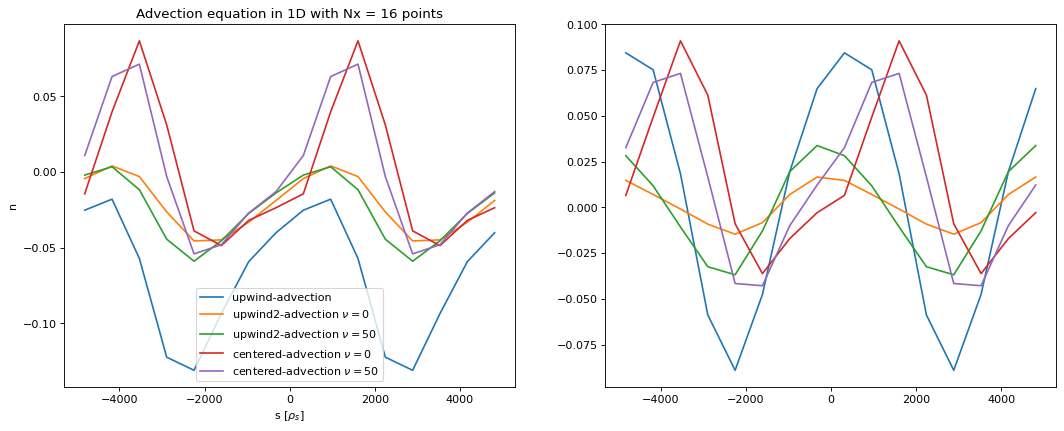

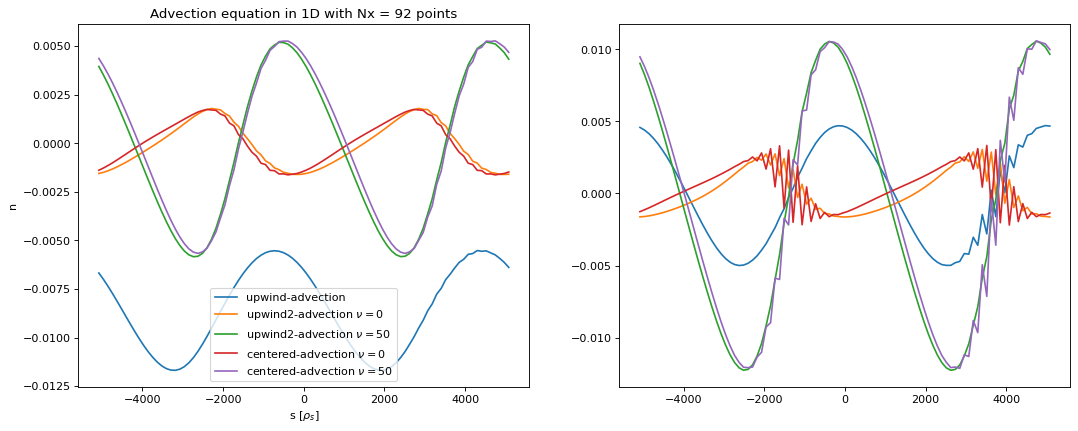

In [13]:
params["grid"]["Nx"] = 16
plot_navier_stokes(params)
params["grid"]["Nx"] = 92
plot_navier_stokes(params)